In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
import torch.nn as nn
import numpy as np
import random
from tqdm import tqdm
import scanpy as sc
import torch.nn.functional as F
from collections import defaultdict
from torch.distributions import Normal, kl_divergence
from torch.optim import lr_scheduler
import scanpy as sc
import numpy as np
import pandas as pd
# from umap.umap_ import UMAP
# from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import cudf
from cuml import PCA, UMAP
import cupy as cp

from model_VAE import VAE
from dataloader_VAE import get_h5ad_data, get_dataloader, normalize, inverse_normalize
from train_VAE import train_vae

# 准备数据

In [3]:
# 准备数据

data_list = get_h5ad_data()
norm_data_list, scalers = normalize(data_list)


# 训练集和测试集对应的下标
train_index = [0, 1, 2, 3, 5, 7, 9, 10, 11]
test_index = [4, 6, 8]

train_list = [norm_data_list[i] for i in train_index]
test_list = [norm_data_list[i] for i in test_index]

train_dataloader = get_dataloader(train_list, train_index, batch_size=64)
test_dataloader = get_dataloader(test_list, test_index, batch_size=64)

# 模型训练

In [9]:
device = "cuda:0"
net = VAE().to(device)

num_epoch = 20
train_vae(net, train_dataloader, num_epoch, device=device)

# 保存模型
model_path = '/home/hanyuji/Results/VAE_result/vae_model_0603.pt'
torch.save(net.state_dict(), model_path)

100%|█████████| 20/20 [00:47<00:00,  2.40s/it, recon_loss=243.076,kl_loss=5.649]


# 模型生成

In [4]:
# 加载模型
device = "cuda:0"
net = VAE().to(device)
model_path = '/home/hanyuji/Results/VAE_result/vae_model_0603.pt'
net.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [5]:
len(test_index)

3

In [6]:
# 准备存放输出
latent_list_mix=[]
latent_dict = {}  # 12个数组 [], [], [], [], [], [], [], [], [], [], [], []
recon_dict = {}  # 12个数组

# {4: [], 6: [], 8: []}
for index in test_index:
    latent_dict[index] = []
    recon_dict[index] = []

In [7]:
net.eval()
for (x, y) in test_dataloader:
    x = x.float().to(device)
    z, mu, var = net.encoder(x)
    recon = net.decoder(z)
    
    z_np = z.detach().cpu().numpy()
    y_np = y.detach().cpu().numpy()
    recon_np = recon.detach().cpu().numpy()
        
    for (z_i,y_i) in zip(z_np,y_np):
        latent_dict[y_i].append(z_i)        
    for (recon_i,y_i) in zip(recon_np,y_np):
        recon_dict[y_i].append(recon_i)
       

In [8]:
latent_list = []
recon_list = []
label_list = []
for index, arr in latent_dict.items():
    latent_list.append(np.asarray(arr))
    for _ in arr:
        label_list.append(index)
    
for index, arr in recon_dict.items():
    recon_list.append(np.asarray(arr))


In [9]:
for i,j in zip(data_list,latent_list):
    print(f'{i.shape}---{j.shape}')

(311, 2000)---(5716, 50)
(200, 2000)---(4101, 50)
(1158, 2000)---(5442, 50)


In [10]:
# latent_list = [latent_list[i] for i in range(3)]
# recon_list = [recon_list[i] for i in range(3)]
# label_list = [item * 4 for item in label_list]

true_array = np.concatenate(data_list, axis=0)
latent_array = np.concatenate(latent_list, axis=0)
recon_array = np.concatenate(recon_list, axis=0)
labels_array = np.asarray(label_list)


print(true_array.shape)
print(latent_array.shape)
print(recon_array.shape)
print(labels_array.shape)

(38731, 2000)
(15259, 50)
(15259, 2000)
(15259,)


# 可视化

In [11]:
device = cp.cuda.Device(0)
device.use()

def linearSegmentCMap(num_colors, cmap_name="plasma"):
    '''Construct colormap for linearly segmented colors.'''
    cm = plt.get_cmap(cmap_name)
    color_list = [cm(i//3*3.0/num_colors) for i in range(num_colors)]
    return color_list

In [12]:
pca_pcs = 15
n_neighbors = 200
min_dist = 0.8


# 构建UMAP模型
umap_model = UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=min_dist)
umap_latent_data = umap_model.fit_transform(latent_array)


# 构建PCA和UMAP模型
pca_model_2 = PCA(n_components=pca_pcs, svd_solver="auto")
umap_model_2 = UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=min_dist)
umap_recon_data = umap_model_2.fit_transform(pca_model_2.fit_transform(recon_array))
# umap_recon_data = umap_model_2.fit_transform(pca_model_2.fit_transform(true_array))



In [13]:
unique_tps = np.unique(labels_array).astype(int).tolist()
unique_tps

[4, 6, 8]

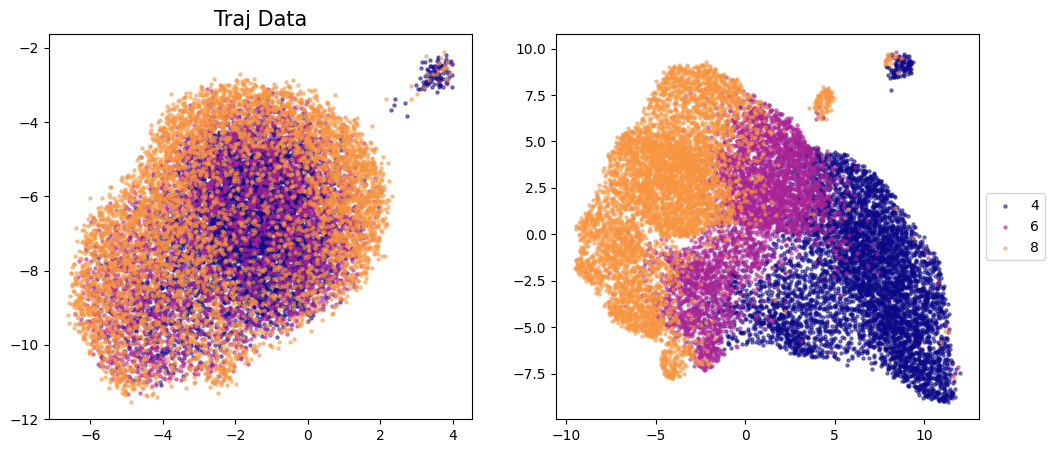

In [14]:
# 画图
'''Plot predictions at all timepoints.'''
unique_tps = np.unique(labels_array).astype(int).tolist()
n_tps = unique_tps[-1]
color_list = linearSegmentCMap(n_tps, cmap_name="plasma")
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.set_title("Traj Data", fontsize=15)
for i, t in enumerate(unique_tps):
    true_t_idx = np.where(labels_array == t)
    ax1.scatter(
        umap_latent_data[true_t_idx, 0],
        umap_latent_data[true_t_idx, 1],
        label=t,
        color=color_list[i*3],
        s=5,
        alpha=0.5,
    )
    ax2.scatter(
        umap_recon_data[true_t_idx, 0],
        umap_recon_data[true_t_idx, 1],
        label=t,
        color=color_list[i*3],
        s=5,
        alpha=0.5,
    )
ax2.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.show()